In [1]:
# Importing Libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
# -------------------------------
# 1. Load and Preprocess the Data
# -------------------------------
supply_data = pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyData.csv')

# Preprocess 'Supply' column by removing commas and converting to numeric
supply_data['Supply'] = supply_data['Supply'].str.replace(',', '').astype(float)

# Convert 'Date' to datetime format
supply_data['Date'] = pd.to_datetime(supply_data['Date'], format='%m/%d/%Y')

# Feature Engineering: Create time-related features
supply_data['DayOfYear'] = supply_data['Date'].dt.dayofyear
supply_data['WeekOfYear'] = supply_data['Date'].dt.isocalendar().week
supply_data['Month'] = supply_data['Date'].dt.month
supply_data['DayOfWeek'] = supply_data['Date'].dt.dayofweek
# -------------------------------
# 2. Define Features and Target
# -------------------------------
features = ['72 Day Temperature', '72 Day Precipitation', 'DayOfYear', 'WeekOfYear', 'Month', 'DayOfWeek']
target = 'Supply'

# Split data into training and testing sets
X = supply_data[features]
y = supply_data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
# -------------------------------
# 3. Train LightGBM Model
# -------------------------------
# Prepare data for LightGBM
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# LightGBM parameters
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

# Train the model
num_round = 1000
model = lgb.train(
    params,
    train_data,
    num_boost_round=num_round,
    valid_sets=[test_data],
    callbacks=[lgb.early_stopping(stopping_rounds=50)],
)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 648
[LightGBM] [Info] Number of data points in the train set: 590, number of used features: 6
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 40139919.642373
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

Model Evaluation:
R²: 0.9365
RMSE: 1742280.99


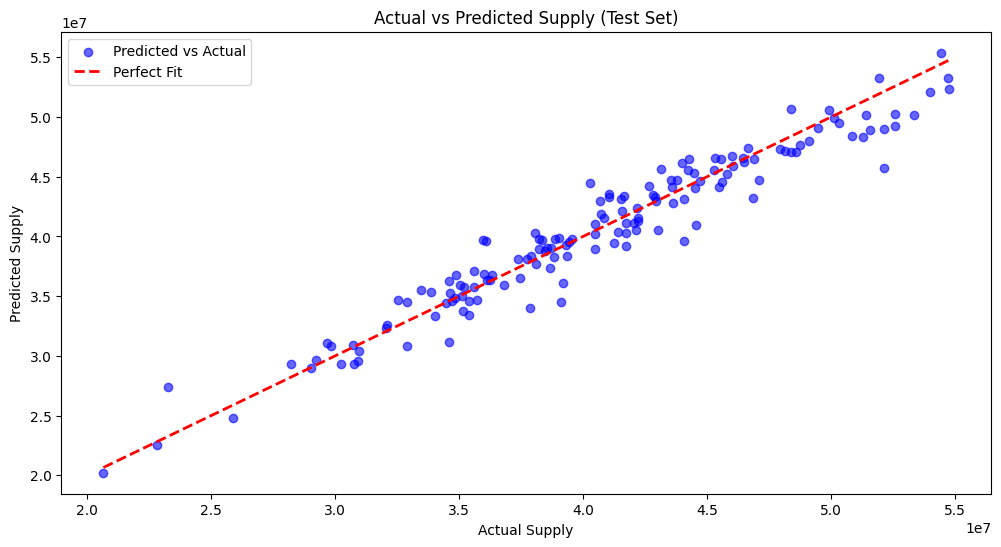

In [4]:
# -------------------------------
# 4. Evaluate the Model
# -------------------------------
# Predictions on test data
y_test_pred = model.predict(X_test)

# Calculate evaluation metrics
r2 = r2_score(y_test, y_test_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Display metrics
print(f"Model Evaluation:\nR²: {r2:.4f}\nRMSE: {rmse:.2f}")

# Plot actual vs predicted on test set
plt.figure(figsize=(12, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6, color='blue', label='Predicted vs Actual')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Fit')
plt.xlabel('Actual Supply')
plt.ylabel('Predicted Supply')
plt.title('Actual vs Predicted Supply (Test Set)')
plt.legend()
plt.show()


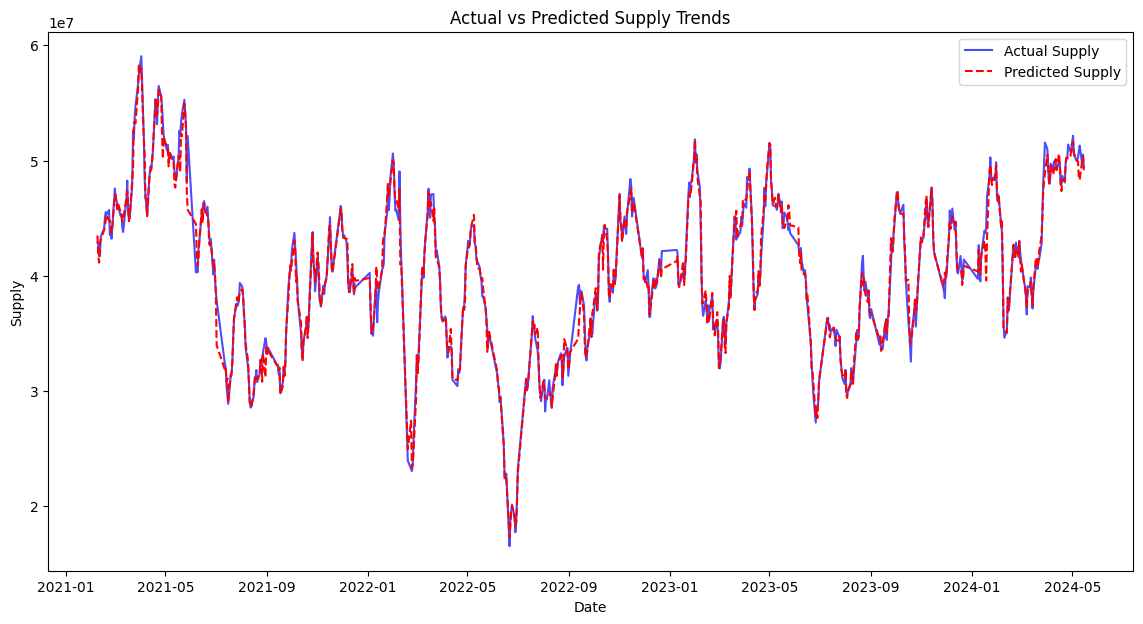

In [5]:
# -------------------------------
# 5. Visualize Trends in Historical Data
# -------------------------------
# Predict for the entire dataset
supply_data['Predicted Supply'] = model.predict(X)

# Plot actual vs predicted trends for the entire dataset
plt.figure(figsize=(14, 7))
plt.plot(supply_data['Date'], supply_data['Supply'], label='Actual Supply', color='blue', alpha=0.7)
plt.plot(supply_data['Date'], supply_data['Predicted Supply'], label='Predicted Supply', color='red', linestyle='--')
plt.title('Actual vs Predicted Supply Trends')
plt.xlabel('Date')
plt.ylabel('Supply')
plt.legend()
plt.show()

In [6]:
# -------------------------------
# 6. Predict Future Supply (Adjustable Time Period)
# -------------------------------

# Note: You can change `time_period` to the desired number of future days to predict.
time_period = 30  # Default is 30 days, but you can adjust this to any number (e.g., 7, 190, etc.)

# Generate future dates
last_date = supply_data['Date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, time_period + 1)]

# Create a DataFrame for future data with the same structure as training data
future_features = pd.DataFrame({
    'Date': future_dates,
    '72 Day Temperature': supply_data['72 Day Temperature'].iloc[-7:].mean(),  # Average temperature from the last 7 days
    '72 Day Precipitation': supply_data['72 Day Precipitation'].iloc[-7:].mean()  # Average precipitation from the last 7 days
})

# Add time-based features to match the training data
future_features['DayOfYear'] = future_features['Date'].dt.dayofyear
future_features['WeekOfYear'] = future_features['Date'].dt.isocalendar().week
future_features['Month'] = future_features['Date'].dt.month
future_features['DayOfWeek'] = future_features['Date'].dt.dayofweek

# Predict supply for the future period
feature_columns = ['72 Day Temperature', '72 Day Precipitation', 'DayOfYear', 'WeekOfYear', 'Month', 'DayOfWeek']
future_features['Supply Prediction'] = model.predict(future_features[feature_columns], num_iteration=model.best_iteration)

# Display predictions in a readable format
future_features_display = future_features.copy()
future_features_display['Supply Prediction'] = future_features_display['Supply Prediction'].apply(lambda x: f"{int(x):,}")
print("Future Predictions:")
print(future_features_display[['Date', 'Supply Prediction']])





Future Predictions:
         Date Supply Prediction
0  2024-05-16        50,353,833
1  2024-05-17        49,888,217
2  2024-05-18        49,888,217
3  2024-05-19        49,888,217
4  2024-05-20        50,495,010
5  2024-05-21        49,845,938
6  2024-05-22        49,761,731
7  2024-05-23        50,193,550
8  2024-05-24        49,692,418
9  2024-05-25        49,606,100
10 2024-05-26        47,446,825
11 2024-05-27        48,517,669
12 2024-05-28        48,440,526
13 2024-05-29        48,035,743
14 2024-05-30        47,968,062
15 2024-05-31        47,446,825
16 2024-06-01        47,446,825
17 2024-06-02        47,446,825
18 2024-06-03        48,517,669
19 2024-06-04        48,440,526
20 2024-06-05        48,035,743
21 2024-06-06        48,002,714
22 2024-06-07        47,481,478
23 2024-06-08        47,221,466
24 2024-06-09        47,024,773
25 2024-06-10        46,091,045
26 2024-06-11        45,998,091
27 2024-06-12        45,117,337
28 2024-06-13        45,037,850
29 2024-06-14       

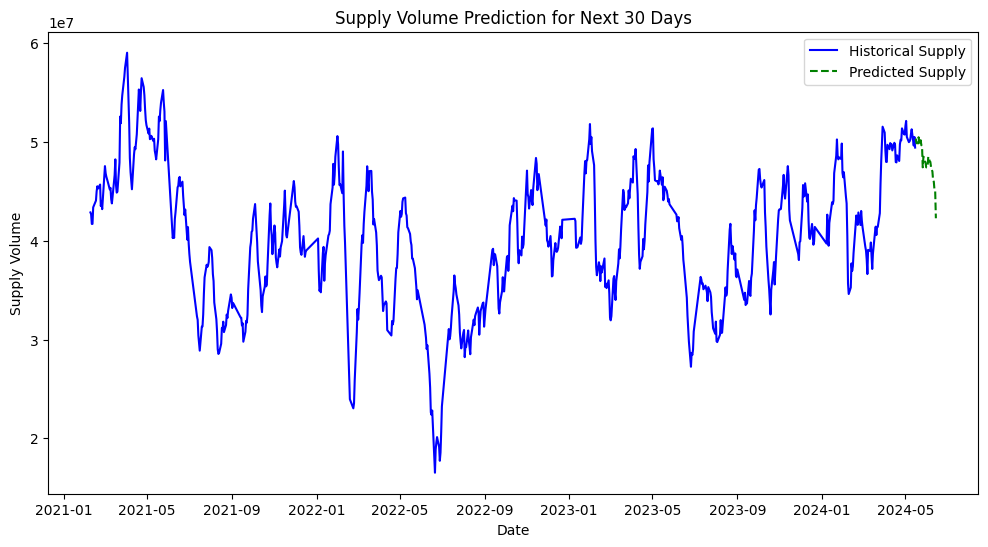

In [7]:
# -------------------------------
# 7. Plot Historical and Future Predictions
# -------------------------------

# Plot historical supply data
plt.figure(figsize=(12, 6))
plt.plot(supply_data['Date'], supply_data['Supply'], label='Historical Supply', color='blue')

# Plot future predictions
plt.plot(future_features['Date'], future_features['Supply Prediction'], label='Predicted Supply', linestyle='--', color='green')

# Customize the plot
plt.xlabel('Date')
plt.ylabel('Supply Volume')
plt.title(f'Supply Volume Prediction for Next {time_period} Days')
plt.legend()
plt.show()


In [8]:
new_supply_data = pd.read_csv('C:/Users/Patron/Desktop/study/fin 850/SupplyDataGraph.csv')
new_supply_data['Date'] = pd.to_datetime(supply_data['Date'])
new_supply_data = new_supply_data.sort_values('Date')
new_supply_data['Supply'] = new_supply_data['Supply'].str.replace(',', '').astype(float)
new_supply_data.set_index('Date', inplace=True)  # Set as index

In [9]:
import lightgbm as lgb
from sklearn.metrics import r2_score
from datetime import timedelta
import numpy as np




# Recalculate Predicted Supply for the historical data if not already done
# Note: Reusing model and feature columns as defined previously in your code
if 'Predicted Supply' not in supply_data.columns:
    supply_data['Predicted Supply'] = model.predict(X, num_iteration=model.best_iteration)

# Merge the new supply data with the predictions from the original dataset
combined_data = pd.merge(supply_data[['Date', 'Predicted Supply']], new_supply_data, on='Date', how='inner')

# Calculate the R-squared value between the predicted and actual supply values
r2_real_vs_predicted = r2_score(combined_data['Supply'], combined_data['Predicted Supply'])

# Display the R-squared value
print(f"R² between Predicted Supply and Real Supply: {r2_real_vs_predicted:.4f}")


R² between Predicted Supply and Real Supply: -4.5706


In [10]:
supply_data

,Date,Supply,72 Day Temperature,72 Day Precipitation,DayOfYear,WeekOfYear,Month,DayOfWeek,Predicted Supply
0,2021-02-08,42880791.0,15.41,0.26,39,6,2,0,4.349423e+07
1,2021-02-09,42698507.0,15.37,0.26,40,6,2,1,4.174883e+07
2,2021-02-10,41714308.0,15.38,0.20,41,6,2,2,4.113996e+07
3,2021-02-11,41718366.0,15.36,0.17,42,6,2,3,4.281385e+07
4,2021-02-12,43395733.0,15.29,0.17,43,6,2,4,4.314946e+07
...,...,...,...,...,...,...,...,...,...
733,2024-05-09,50845562.0,27.10,3.79,130,19,5,3,4.837494e+07
734,2024-05-10,51298151.0,27.11,3.99,131,19,5,4,4.833209e+07
735,2024-05-13,49646488.0,27.17,4.24,134,20,5,0,4.999033e+07
736,2024-05-14,50518797.0,27.19,4.35,135,20,5,1,5.037682e+07
